In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 13:34 - loss: 0.0791 - STD: 1.9017e-04 - MAE: 0.2651

  2/793 [..............................] - ETA: 6:12 - loss: 0.0473 - STD: 3.9806e-04 - MAE: 0.1783 

 12/793 [..............................] - ETA: 37s - loss: 0.0257 - STD: 2.0650e-04 - MAE: 0.1258 

 21/793 [..............................] - ETA: 22s - loss: 0.0198 - STD: 1.5818e-04 - MAE: 0.1087

 30/793 [>.............................] - ETA: 16s - loss: 0.0171 - STD: 1.4093e-04 - MAE: 0.1012

 39/793 [>.............................] - ETA: 13s - loss: 0.0154 - STD: 1.3644e-04 - MAE: 0.0950

 48/793 [>.............................] - ETA: 11s - loss: 0.0142 - STD: 1.4259e-04 - MAE: 0.0919

 57/793 [=>............................] - ETA: 10s - loss: 0.0134 - STD: 1.5239e-04 - MAE: 0.0890

 66/793 [=>............................] - ETA: 9s - loss: 0.0129 - STD: 1.6790e-04 - MAE: 0.0873 

 75/793 [=>............................] - ETA: 8s - loss: 0.0124 - STD: 1.8855e-04 - MAE: 0.0859

 84/793 [==>...........................] - ETA: 8s - loss: 0.0121 - STD: 2.1540e-04 - MAE: 0.0848

 93/793 [==>...........................] - ETA: 7s - loss: 0.0119 - STD: 2.5147e-04 - MAE: 0.0841

102/793 [==>...........................] - ETA: 7s - loss: 0.0117 - STD: 2.9953e-04 - MAE: 0.0833

111/793 [===>..........................] - ETA: 6s - loss: 0.0115 - STD: 3.6534e-04 - MAE: 0.0827

120/793 [===>..........................] - ETA: 6s - loss: 0.0113 - STD: 4.5856e-04 - MAE: 0.0821

129/793 [===>..........................] - ETA: 6s - loss: 0.0111 - STD: 5.9854e-04 - MAE: 0.0815

138/793 [====>.........................] - ETA: 6s - loss: 0.0110 - STD: 8.1533e-04 - MAE: 0.0810

147/793 [====>.........................] - ETA: 5s - loss: 0.0108 - STD: 0.0012 - MAE: 0.0806    

156/793 [====>.........................] - ETA: 5s - loss: 0.0107 - STD: 0.0017 - MAE: 0.0802

165/793 [=====>........................] - ETA: 5s - loss: 0.0105 - STD: 0.0026 - MAE: 0.0797

174/793 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0039 - MAE: 0.0790

183/793 [=====>........................] - ETA: 5s - loss: 0.0102 - STD: 0.0054 - MAE: 0.0784

192/793 [======>.......................] - ETA: 5s - loss: 0.0101 - STD: 0.0069 - MAE: 0.0779

201/793 [======>.......................] - ETA: 4s - loss: 0.0099 - STD: 0.0083 - MAE: 0.0773

210/793 [======>.......................] - ETA: 4s - loss: 0.0098 - STD: 0.0098 - MAE: 0.0768

219/793 [=======>......................] - ETA: 4s - loss: 0.0097 - STD: 0.0112 - MAE: 0.0763

228/793 [=======>......................] - ETA: 4s - loss: 0.0096 - STD: 0.0124 - MAE: 0.0758

237/793 [=======>......................] - ETA: 4s - loss: 0.0095 - STD: 0.0136 - MAE: 0.0754

246/793 [========>.....................] - ETA: 4s - loss: 0.0094 - STD: 0.0147 - MAE: 0.0750

255/793 [========>.....................] - ETA: 4s - loss: 0.0093 - STD: 0.0159 - MAE: 0.0746

264/793 [========>.....................] - ETA: 4s - loss: 0.0092 - STD: 0.0170 - MAE: 0.0741

273/793 [=========>....................] - ETA: 4s - loss: 0.0091 - STD: 0.0181 - MAE: 0.0736

282/793 [=========>....................] - ETA: 3s - loss: 0.0089 - STD: 0.0193 - MAE: 0.0730

291/793 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.0205 - MAE: 0.0726

299/793 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.0215 - MAE: 0.0722

307/793 [==========>...................] - ETA: 3s - loss: 0.0087 - STD: 0.0224 - MAE: 0.0718

315/793 [==========>...................] - ETA: 3s - loss: 0.0086 - STD: 0.0233 - MAE: 0.0713

324/793 [===========>..................] - ETA: 3s - loss: 0.0085 - STD: 0.0243 - MAE: 0.0709

333/793 [===========>..................] - ETA: 3s - loss: 0.0084 - STD: 0.0252 - MAE: 0.0705

342/793 [===========>..................] - ETA: 3s - loss: 0.0083 - STD: 0.0261 - MAE: 0.0701

351/793 [============>.................] - ETA: 3s - loss: 0.0082 - STD: 0.0270 - MAE: 0.0696

359/793 [============>.................] - ETA: 3s - loss: 0.0082 - STD: 0.0278 - MAE: 0.0693

367/793 [============>.................] - ETA: 3s - loss: 0.0081 - STD: 0.0286 - MAE: 0.0689

375/793 [=============>................] - ETA: 3s - loss: 0.0080 - STD: 0.0293 - MAE: 0.0687

384/793 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.0300 - MAE: 0.0683

392/793 [=============>................] - ETA: 2s - loss: 0.0079 - STD: 0.0307 - MAE: 0.0679

400/793 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0314 - MAE: 0.0676

408/793 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0320 - MAE: 0.0673

416/793 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0325 - MAE: 0.0670

424/793 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.0331 - MAE: 0.0667

433/793 [===============>..............] - ETA: 2s - loss: 0.0076 - STD: 0.0338 - MAE: 0.0664

442/793 [===============>..............] - ETA: 2s - loss: 0.0075 - STD: 0.0344 - MAE: 0.0661

451/793 [================>.............] - ETA: 2s - loss: 0.0075 - STD: 0.0351 - MAE: 0.0658

460/793 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0357 - MAE: 0.0655

469/793 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0362 - MAE: 0.0652

478/793 [=================>............] - ETA: 2s - loss: 0.0073 - STD: 0.0368 - MAE: 0.0649

487/793 [=================>............] - ETA: 2s - loss: 0.0073 - STD: 0.0374 - MAE: 0.0647

496/793 [=================>............] - ETA: 2s - loss: 0.0072 - STD: 0.0379 - MAE: 0.0644

505/793 [==================>...........] - ETA: 2s - loss: 0.0072 - STD: 0.0385 - MAE: 0.0641

514/793 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0389 - MAE: 0.0639

523/793 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0394 - MAE: 0.0636

532/793 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0398 - MAE: 0.0634

541/793 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0403 - MAE: 0.0632

549/793 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0407 - MAE: 0.0630

558/793 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0627

567/793 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0416 - MAE: 0.0625

576/793 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0420 - MAE: 0.0623

585/793 [=====================>........] - ETA: 1s - loss: 0.0068 - STD: 0.0424 - MAE: 0.0621

594/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0428 - MAE: 0.0619

603/793 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0432 - MAE: 0.0617

612/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0436 - MAE: 0.0615

621/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0440 - MAE: 0.0613

630/793 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.0443 - MAE: 0.0611

639/793 [=======================>......] - ETA: 1s - loss: 0.0065 - STD: 0.0447 - MAE: 0.0609

648/793 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0450 - MAE: 0.0607

657/793 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0454 - MAE: 0.0606

666/793 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0457 - MAE: 0.0604

675/793 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0460 - MAE: 0.0603

684/793 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0462 - MAE: 0.0601

693/793 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0465 - MAE: 0.0600

702/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0468 - MAE: 0.0599

710/793 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0470 - MAE: 0.0598

719/793 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0473 - MAE: 0.0596

728/793 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0476 - MAE: 0.0595

737/793 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0478 - MAE: 0.0593

746/793 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0481 - MAE: 0.0592

755/793 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0484 - MAE: 0.0590

764/793 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0487 - MAE: 0.0589

773/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0490 - MAE: 0.0587

782/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0492 - MAE: 0.0586

791/793 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0495 - MAE: 0.0585

793/793 [==============================] - 7s 7ms/step - loss: 0.0061 - STD: 0.0496 - MAE: 0.0584 - val_loss: 0.0042 - val_STD: 0.0483 - val_MAE: 0.0461


Epoch 2/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0493

 10/793 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0485 

 19/793 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0483

 28/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

 37/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0477

 46/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

 55/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0473

 63/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

 70/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0471

 78/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

 87/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

 92/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0468

 99/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

108/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

117/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466

125/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

134/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0464

143/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

152/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

161/793 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

170/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0462

179/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0462

188/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0462

197/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

206/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

215/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

224/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

232/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0463

240/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0463

249/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0463

258/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0462

267/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0463

276/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0462

285/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0462

294/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0462

303/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0462

312/793 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

321/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

330/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

339/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

348/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

357/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

365/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

374/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

383/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

392/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

401/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

410/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

419/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

428/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

437/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

446/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

455/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

464/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

473/793 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

482/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

491/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

500/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

509/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

517/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

524/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

533/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

541/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

549/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

558/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

567/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

576/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

584/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

593/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

601/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

609/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

618/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

626/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

635/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

644/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

653/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

662/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

671/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

680/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

689/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

698/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

707/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

716/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

725/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

733/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

741/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

750/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

759/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

768/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

777/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

786/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

793/793 [==============================] - 5s 7ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452 - val_loss: 0.0038 - val_STD: 0.0517 - val_MAE: 0.0433


Epoch 3/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0038 - STD: 0.0629 - MAE: 0.0442

  9/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0713 - MAE: 0.0446 

 17/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0449

 25/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

 33/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0448

 41/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0449

 50/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0446

 59/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

 67/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

 74/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

 83/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

 92/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

101/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

110/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

118/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

126/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

135/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

144/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

153/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

159/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

166/793 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

175/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

184/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

193/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

202/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

210/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

218/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

227/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

236/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

245/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

253/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

261/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

270/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

278/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

287/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

296/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

304/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

312/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

321/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

330/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

339/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

348/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

356/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

365/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

374/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

383/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

392/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

401/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

410/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

418/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

426/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

434/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

443/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

452/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

461/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

470/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

479/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

488/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

497/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

506/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

514/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

523/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

532/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

541/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

550/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

559/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

568/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

577/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

586/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

595/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

604/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

613/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

622/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

631/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

640/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

649/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

658/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

667/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

676/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

685/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

694/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

703/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

711/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

720/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

729/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

738/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

746/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

755/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

764/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

773/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

782/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

791/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

793/793 [==============================] - 5s 6ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435 - val_loss: 0.0029 - val_STD: 0.0602 - val_MAE: 0.0396


Epoch 4/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

 10/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425 

 19/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 28/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

 37/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

 45/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 54/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

 63/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

 72/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 81/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 90/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

 99/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

108/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

117/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

126/793 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

135/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

143/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

152/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

161/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

170/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

179/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

188/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

197/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

206/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

215/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

224/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

233/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

242/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

251/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

260/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

269/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

278/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

287/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

296/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

305/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

314/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

323/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

331/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

340/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

349/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

358/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

366/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

375/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

384/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

393/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

402/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

411/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

420/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

428/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

437/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

446/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

455/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

464/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

473/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

482/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

491/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

500/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

509/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

517/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

525/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

534/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

543/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

552/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

561/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

569/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

578/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

586/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

595/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

604/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

613/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

622/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

631/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

640/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

649/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

658/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

666/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

674/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

683/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

692/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

701/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

710/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

719/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

728/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

737/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

746/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

755/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

764/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

773/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

781/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

790/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423 - val_loss: 0.0028 - val_STD: 0.0623 - val_MAE: 0.0390


Epoch 5/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0027 - STD: 0.0820 - MAE: 0.0392

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0411 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0407

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

 36/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

 45/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 54/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 63/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 72/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 80/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 89/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

 98/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

107/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

116/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

124/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

133/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

142/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

151/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

160/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

169/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

178/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

187/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

196/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

205/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

214/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

223/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

232/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

241/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

249/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

258/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

267/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

276/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

285/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

294/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

303/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

312/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

321/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

330/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

339/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

347/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

356/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

364/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

373/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

382/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

391/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

399/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

408/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

417/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

426/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

435/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

444/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

453/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

461/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

470/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

479/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

488/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

497/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

505/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

514/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

523/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

531/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

540/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

549/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

558/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

567/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

576/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

585/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

594/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

603/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

612/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

621/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

630/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

639/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

648/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

657/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

666/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

675/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

684/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

693/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

702/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

711/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

719/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

728/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

737/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

746/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

755/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

764/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

773/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

782/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

791/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0619 - val_MAE: 0.0384


Epoch 6/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0403

  8/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0408 

 16/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

 25/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

 34/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

 43/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 52/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 61/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 97/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

106/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

115/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

124/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

133/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

142/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

151/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

160/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

169/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

178/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

187/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

196/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

205/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

214/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

223/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

232/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

241/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

250/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

258/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

267/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

276/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

285/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

294/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

303/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

312/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

320/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

329/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

338/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

347/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

356/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

365/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

374/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

383/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

392/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

401/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

410/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

419/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

428/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

437/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

446/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

455/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

464/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

473/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

482/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

491/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

500/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

509/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

518/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

527/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

536/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

545/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

554/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

563/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

570/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

579/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

588/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

597/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

606/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

615/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

624/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

633/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

642/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

651/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

660/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

669/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

678/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

687/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

696/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

705/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

714/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

723/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

732/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

741/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

750/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

759/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

768/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

777/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

786/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0582 - val_MAE: 0.0381


Epoch 7/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0410

 10/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0400 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0774 - MAE: 0.0396

 28/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

 37/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

 45/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 62/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0405

 78/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 87/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 96/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

104/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

113/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

122/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

139/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

148/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

157/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0400

166/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

175/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

183/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

192/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

201/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

210/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

219/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

228/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

237/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

246/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

255/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

264/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

273/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

282/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

291/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

300/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

309/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

318/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

327/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

336/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

354/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

363/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

372/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

381/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

390/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

399/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

408/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

416/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

424/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

433/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

442/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

451/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

459/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

468/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

477/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

486/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

495/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

504/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

513/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

522/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

531/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

540/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

549/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

558/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

567/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

576/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

585/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

594/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

603/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

612/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

629/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

647/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

674/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

692/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

701/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

710/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

719/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

728/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

746/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

764/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

773/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

791/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0593 - val_MAE: 0.0382


Epoch 8/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0377

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0395 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 28/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 36/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

 45/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

 54/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 62/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

 71/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

 80/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 89/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

 98/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

107/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

116/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

125/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

133/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

141/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

150/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

159/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

166/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

174/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

183/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

192/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

200/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

206/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

211/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

216/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

224/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

233/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

242/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

251/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

260/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

269/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

277/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

286/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

294/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

303/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

312/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

330/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

339/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

348/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

357/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

366/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

375/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

384/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

392/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

398/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

407/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

416/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

424/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

437/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

442/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

449/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

458/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

467/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

476/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

485/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

494/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

503/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

512/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

521/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

528/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

537/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

545/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

552/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

557/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

563/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

572/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

581/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

590/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

599/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

608/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

616/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

625/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

634/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

643/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

652/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

661/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

670/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

679/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

688/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

697/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

706/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

715/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

724/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

733/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

741/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

749/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

767/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

776/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

782/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

787/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392 - val_loss: 0.0036 - val_STD: 0.0529 - val_MAE: 0.0415


Epoch 9/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0432

  9/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0403

 26/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

 42/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0399

 49/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 58/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 67/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 75/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 83/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 88/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 93/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 99/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

106/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

115/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

124/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

133/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

141/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

149/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

157/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

166/793 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

175/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

184/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

193/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

202/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

211/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

220/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

229/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

238/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

247/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

256/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

265/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

274/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

283/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

292/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

301/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

309/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

317/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

323/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

332/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

341/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

350/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

358/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

363/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

368/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

373/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

381/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

390/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

399/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

408/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

417/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

426/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

435/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

442/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

450/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

457/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

465/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

473/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

481/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

489/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

497/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

505/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

514/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

523/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

532/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

540/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

548/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

557/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

566/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

575/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

583/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

592/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

601/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

610/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

619/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

628/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

637/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

646/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

655/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

663/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

672/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

681/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

690/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

699/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

708/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

717/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

726/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

735/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

744/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

753/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

762/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

770/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

778/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

787/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.0614 - val_MAE: 0.0371


Epoch 10/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0398

  9/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0389 

 17/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 24/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

 31/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 39/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 47/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

 54/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

 62/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

 69/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

 77/793 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

 84/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 91/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 98/793 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

106/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

113/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

120/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

127/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

135/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

142/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

149/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

156/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

163/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

170/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

177/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

184/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

190/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

196/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

202/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

208/793 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

214/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

220/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

227/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

234/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

240/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

247/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

253/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

261/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

267/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

275/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

283/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

291/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

299/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

308/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

317/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

325/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

333/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

342/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

351/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

359/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

367/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

375/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

383/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

391/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

399/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

408/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

416/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

423/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

431/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

439/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

447/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

455/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

464/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

473/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

482/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

490/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

499/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

508/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

516/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

524/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

531/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

539/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

547/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

556/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

565/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

573/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

582/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

590/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

599/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

608/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

617/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

626/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

635/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

644/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

652/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

660/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

669/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

678/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

687/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

696/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

705/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

713/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

721/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

730/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

739/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

748/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

757/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

766/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

774/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

782/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

791/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

793/793 [==============================] - 6s 7ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384 - val_loss: 0.0026 - val_STD: 0.0654 - val_MAE: 0.0367


Epoch 11/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0377

  9/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0383 

 18/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

 27/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

 35/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

 44/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

 51/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

 59/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0383

 68/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 77/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 86/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

 95/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

103/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

111/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

120/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

129/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

138/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

147/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

156/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

164/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

172/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

181/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

190/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

199/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

207/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

215/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

223/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

232/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

241/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

250/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

259/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

267/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

275/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

283/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

292/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

301/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

309/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

318/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

325/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

333/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

342/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

350/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

358/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

367/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

375/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

383/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

391/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

400/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

409/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

418/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

427/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

435/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

443/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

452/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

461/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

470/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

479/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

487/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

495/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

503/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

512/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

521/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

530/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

539/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

547/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

554/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

562/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

570/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

579/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

588/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

597/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

606/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

613/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

621/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

630/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

639/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

648/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

656/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

665/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

680/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

688/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

697/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

706/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

715/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

724/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

731/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

739/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

748/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

757/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

766/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

775/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

783/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

791/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380 - val_loss: 0.0027 - val_STD: 0.0641 - val_MAE: 0.0394


Epoch 12/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

  9/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0779 - MAE: 0.0383 

 18/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0390

 27/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0388

 36/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

 45/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0384

 54/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0383

 62/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 70/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

 79/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 88/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

 97/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

114/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

122/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

131/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

140/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

149/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

158/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

167/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

174/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

182/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

191/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

199/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

206/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

215/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

224/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

232/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

240/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

248/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

257/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

266/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

275/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

284/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

293/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

301/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

309/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

317/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

326/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

335/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

343/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

351/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

359/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

368/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

377/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

386/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

395/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

404/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

411/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

419/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

428/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

446/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

455/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

463/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

470/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

478/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

487/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

495/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

504/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

513/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

522/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

530/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

538/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

547/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

556/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

565/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

574/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

583/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

591/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

599/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

608/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

617/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

626/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

635/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

643/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

651/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

659/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

668/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

677/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

686/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

695/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

703/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

711/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

720/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

729/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

738/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

747/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

756/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

764/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

773/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

782/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

791/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

793/793 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377 - val_loss: 0.0025 - val_STD: 0.0639 - val_MAE: 0.0365


Epoch 13/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0025 - STD: 0.0826 - MAE: 0.0365

  9/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372 

 18/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

 27/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0801 - MAE: 0.0370

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0801 - MAE: 0.0370

 43/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0372

 52/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0373

 61/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0372

 70/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 79/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

 88/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

 96/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

104/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

112/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

121/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

130/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

147/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

155/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

163/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

172/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

181/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

189/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

198/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

207/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

216/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

223/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

231/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

240/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

249/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

258/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

267/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

274/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

282/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

290/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

298/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

307/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

316/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

325/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

333/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

341/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

350/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

359/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

368/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

377/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

385/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

392/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

410/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

419/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

428/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

445/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

453/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

461/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

470/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

479/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

488/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

496/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

504/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

513/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

522/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

530/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

539/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

548/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

556/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

564/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

573/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

582/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

591/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

600/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

609/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

617/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

625/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

634/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

643/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

652/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

661/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

669/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

677/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

686/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

695/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

704/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

713/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

722/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

730/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

738/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

747/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

756/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

765/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

774/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

782/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

790/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

793/793 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370 - val_loss: 0.0029 - val_STD: 0.0604 - val_MAE: 0.0379


Epoch 14/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0025 - STD: 0.0757 - MAE: 0.0363

  8/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382 

 16/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 25/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 34/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 43/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

 52/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369

 60/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369

 68/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

 76/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

 85/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

 94/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0370

103/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0369

112/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

121/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

129/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

137/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

145/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

154/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

163/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

172/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

181/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

190/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

197/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

205/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

214/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

223/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

232/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

241/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

249/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

257/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

266/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

275/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

283/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

292/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

301/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

308/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

316/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

325/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

334/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

343/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

352/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

360/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

368/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

394/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

403/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

412/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

420/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

428/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

446/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

455/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

464/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

472/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

479/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

487/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

495/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

504/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

512/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

521/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

529/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

536/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

545/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

554/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

563/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

572/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

581/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

588/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

596/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

605/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

632/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

640/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

648/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

656/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

665/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

674/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

692/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

699/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

707/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

716/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

751/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

759/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

767/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

776/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

784/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

793/793 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368 - val_loss: 0.0026 - val_STD: 0.0665 - val_MAE: 0.0366


Epoch 15/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0342

 10/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0355 

 19/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0361

 28/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0367

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

 43/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

 52/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

 60/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

 69/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

 77/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

 84/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

 91/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 99/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

108/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

116/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

125/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

134/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

142/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

150/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

159/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

167/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

176/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

185/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

194/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

203/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

212/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

220/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

228/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

237/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

246/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

254/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

262/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

271/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

278/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

286/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

295/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

313/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

322/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

331/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

339/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

346/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

355/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

364/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

373/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

382/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

391/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

399/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

407/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

416/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

425/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

434/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

442/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

451/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

459/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

468/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

477/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

486/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

495/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

504/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

512/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

520/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

529/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

538/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

547/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

556/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

564/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

571/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

579/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

588/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

597/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

605/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

631/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

640/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

649/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

657/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

665/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

674/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

692/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

701/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

709/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0026 - val_STD: 0.0663 - val_MAE: 0.0378


Epoch 16/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0025 - STD: 0.0837 - MAE: 0.0376

 10/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0803 - MAE: 0.0363 

 19/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0364

 28/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 36/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0361

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0362

 51/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 60/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

 69/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

 78/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

 87/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

 96/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

103/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

111/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

120/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

129/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

138/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

147/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

156/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

163/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

171/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

180/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

189/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

198/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

207/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

216/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

223/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

231/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

240/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

249/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

258/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

267/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

275/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

283/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

291/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

299/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

308/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

317/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

326/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

352/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

361/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

370/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

379/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

386/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

392/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

401/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

410/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

419/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

426/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

431/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

436/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

443/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

452/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

461/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

470/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

479/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

488/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

497/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

504/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

511/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

519/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

527/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

536/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

545/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

554/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

563/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

572/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

581/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

589/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

598/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

607/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

616/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

625/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

634/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

650/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

657/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

666/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

675/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

683/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

690/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

695/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

700/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

708/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

717/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

725/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

733/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

742/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

750/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

759/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

765/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

773/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

782/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

790/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361 - val_loss: 0.0027 - val_STD: 0.0661 - val_MAE: 0.0378


Epoch 17/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0024 - STD: 0.0832 - MAE: 0.0363

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

 25/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

 32/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0358

 40/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0832 - MAE: 0.0357

 48/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

 56/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

 65/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0357

 74/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0358

 83/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0830 - MAE: 0.0358

 92/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0357

101/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0357

110/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

119/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

128/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

137/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

146/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

155/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

164/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

173/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

181/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

188/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

197/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

206/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

212/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

223/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

232/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

241/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

250/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

259/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

268/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

276/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

282/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

290/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

299/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

308/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

316/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

323/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

328/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

333/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

341/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

350/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

368/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

377/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

386/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

394/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

401/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

408/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

416/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

424/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

432/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

441/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

450/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

459/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

468/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

477/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

486/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

495/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

504/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

513/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

522/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

531/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

540/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

549/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

558/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

566/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

575/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

584/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

592/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

598/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

606/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

615/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

624/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

632/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

638/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

648/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

655/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

663/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

671/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

680/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

688/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

697/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

705/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

713/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

720/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

727/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

735/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

742/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

750/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

757/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

765/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

773/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

781/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

790/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

793/793 [==============================] - 6s 7ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357 - val_loss: 0.0027 - val_STD: 0.0632 - val_MAE: 0.0368


Epoch 18/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0022 - STD: 0.0789 - MAE: 0.0345

  9/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0351 

 18/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

 27/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 36/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

 45/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

 54/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

 63/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 72/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

 81/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

 90/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

 99/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

108/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0355

117/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0355

126/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

135/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

143/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

152/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

161/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

170/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

179/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

188/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

197/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

205/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

214/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

223/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

232/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

241/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

250/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

259/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

268/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

277/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

286/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

293/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

302/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

311/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

319/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

326/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

333/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

342/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

349/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

355/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

364/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

373/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

381/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

389/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

398/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

406/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

414/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

422/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

430/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

438/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

446/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

454/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

462/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

470/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

477/793 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

484/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

490/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

498/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

505/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

513/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

521/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

529/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

537/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

546/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

555/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

563/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

571/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

579/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

587/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

595/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

603/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

611/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

619/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

627/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0355

635/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

644/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

653/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

661/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

669/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

677/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

685/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

693/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

702/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

711/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0355

720/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0355

729/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

737/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

745/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

754/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

763/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

772/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

781/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

790/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

793/793 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355 - val_loss: 0.0026 - val_STD: 0.0664 - val_MAE: 0.0379


Epoch 19/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0357

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0819 - MAE: 0.0341 

 19/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0818 - MAE: 0.0347

 28/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0822 - MAE: 0.0350

 37/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0351

 46/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0352

 55/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

 64/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

 73/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

 82/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

 91/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0352

100/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

109/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

118/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

127/793 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

136/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0356

145/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0355

154/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

163/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0356

171/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

180/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

189/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

198/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

207/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

216/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0354

225/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

234/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

243/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

252/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

260/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

269/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

278/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

286/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

295/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

304/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

313/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

322/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

331/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

349/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

358/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

367/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

376/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

383/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

392/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

401/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

410/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

419/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

428/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

436/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

445/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

453/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

462/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

471/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

480/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

489/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

498/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0352

507/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

516/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

525/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

534/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

543/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

552/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

561/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

570/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

579/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

588/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

597/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

606/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

615/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

623/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

632/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

641/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

650/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

659/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

667/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

675/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

684/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

693/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

702/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

711/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

720/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

729/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

738/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

747/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

756/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

765/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

774/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

783/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

792/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

793/793 [==============================] - 5s 6ms/step - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0382


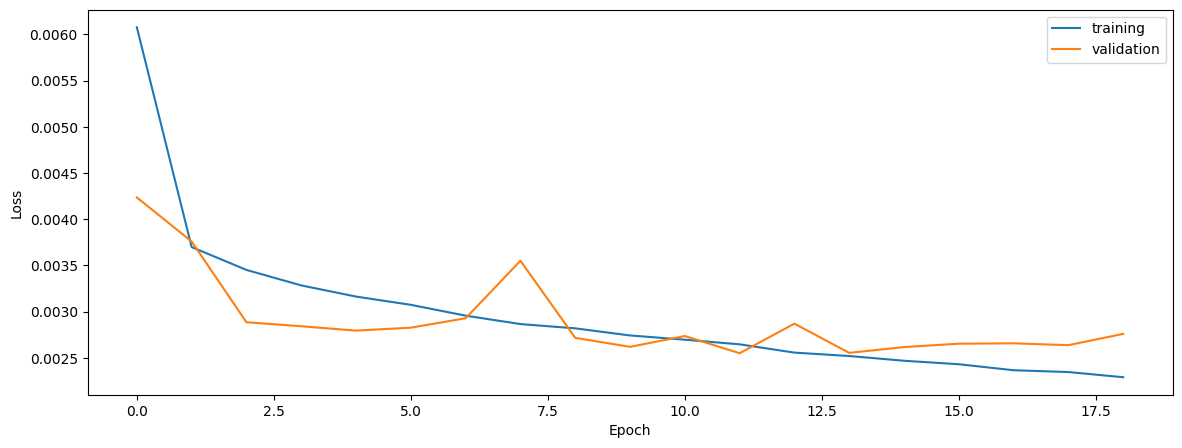

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8522522017549204
0.8391268190105307
0.8213443389627595


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.852626516893152
0.8520873592386821
0.8300535617062775


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8508235684239883
0.8497538542543541
0.8266479135512544


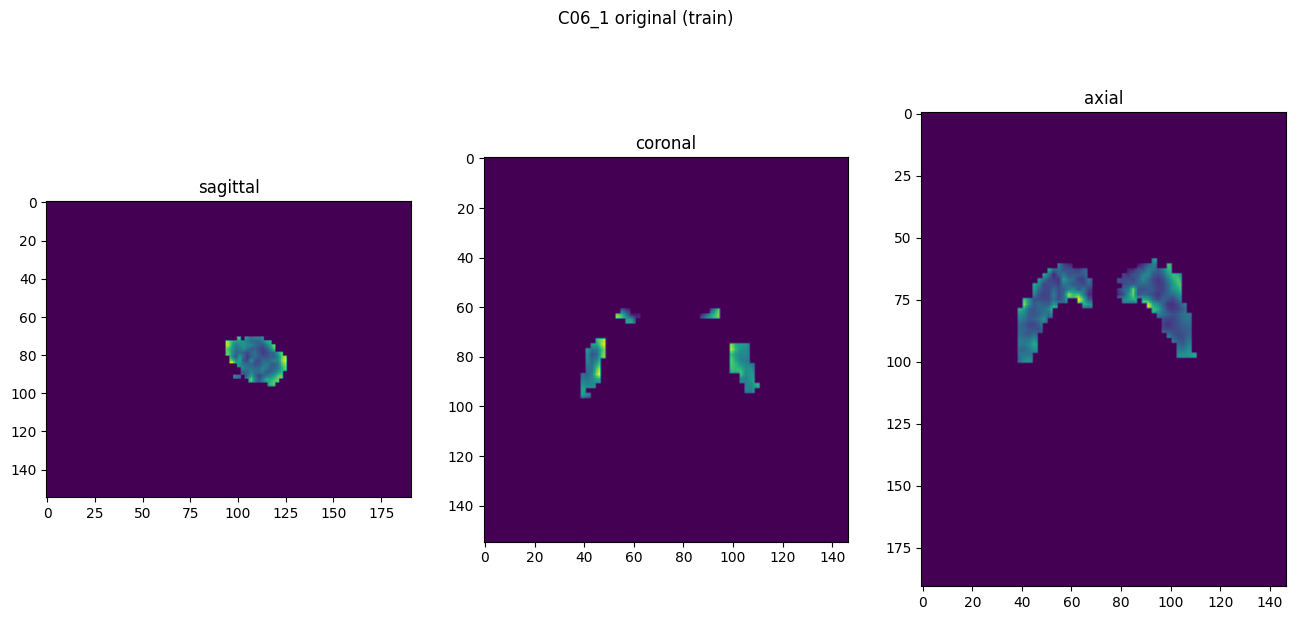

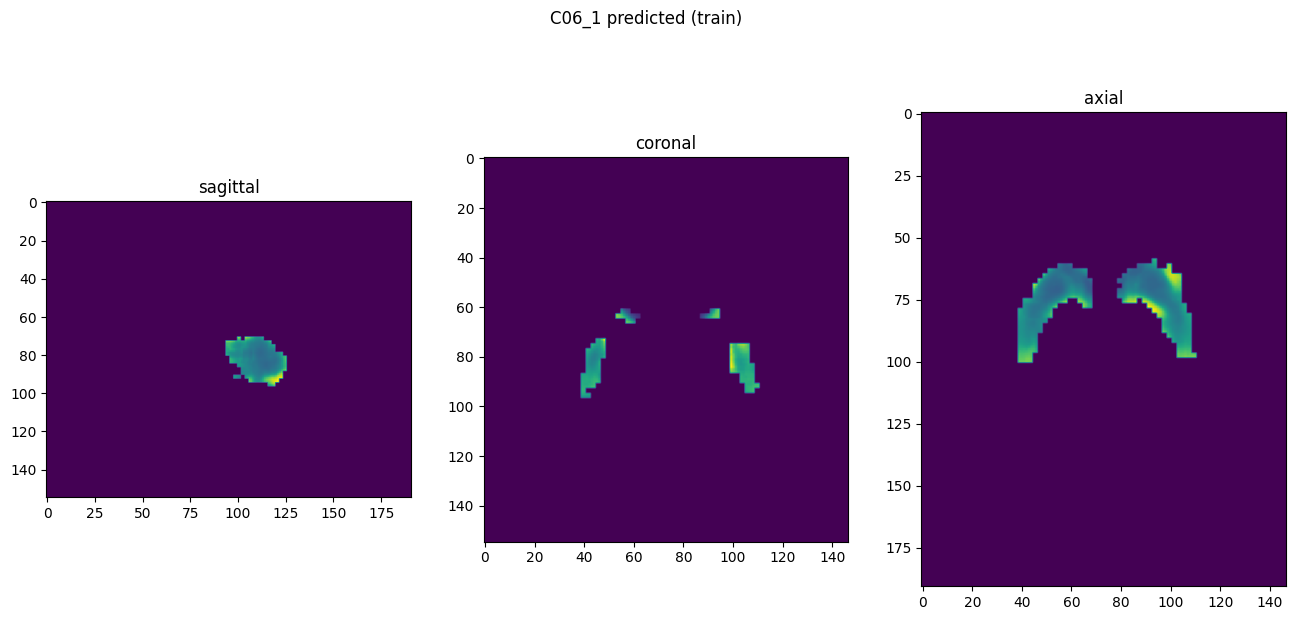

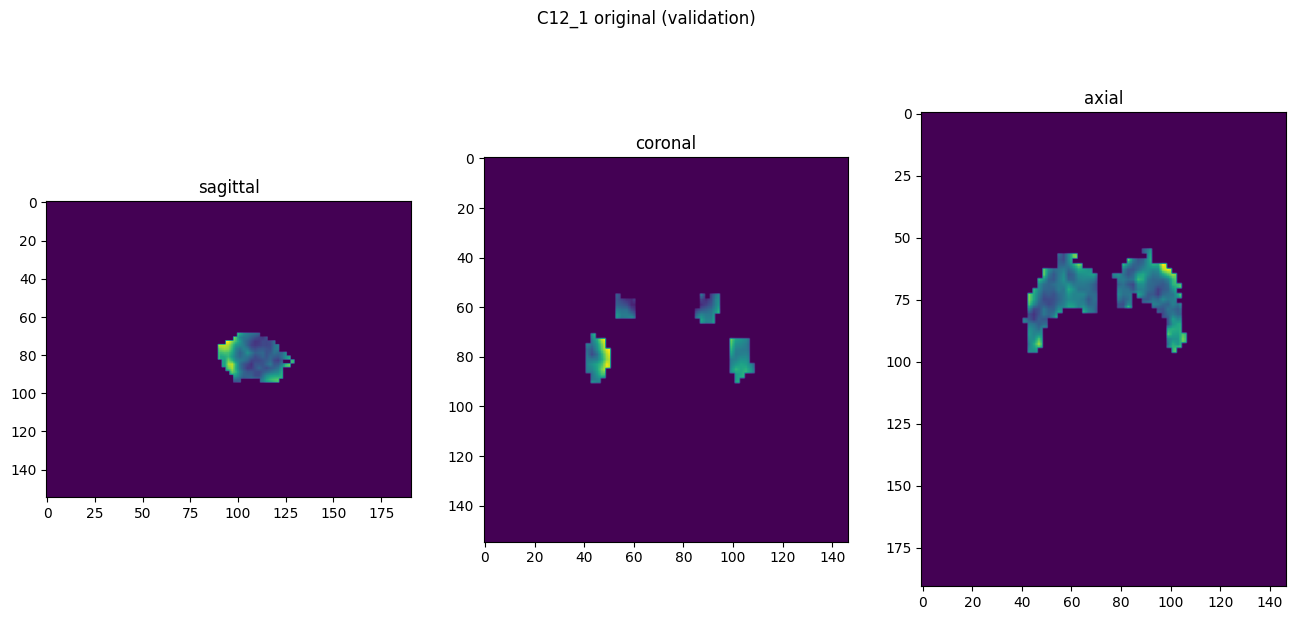

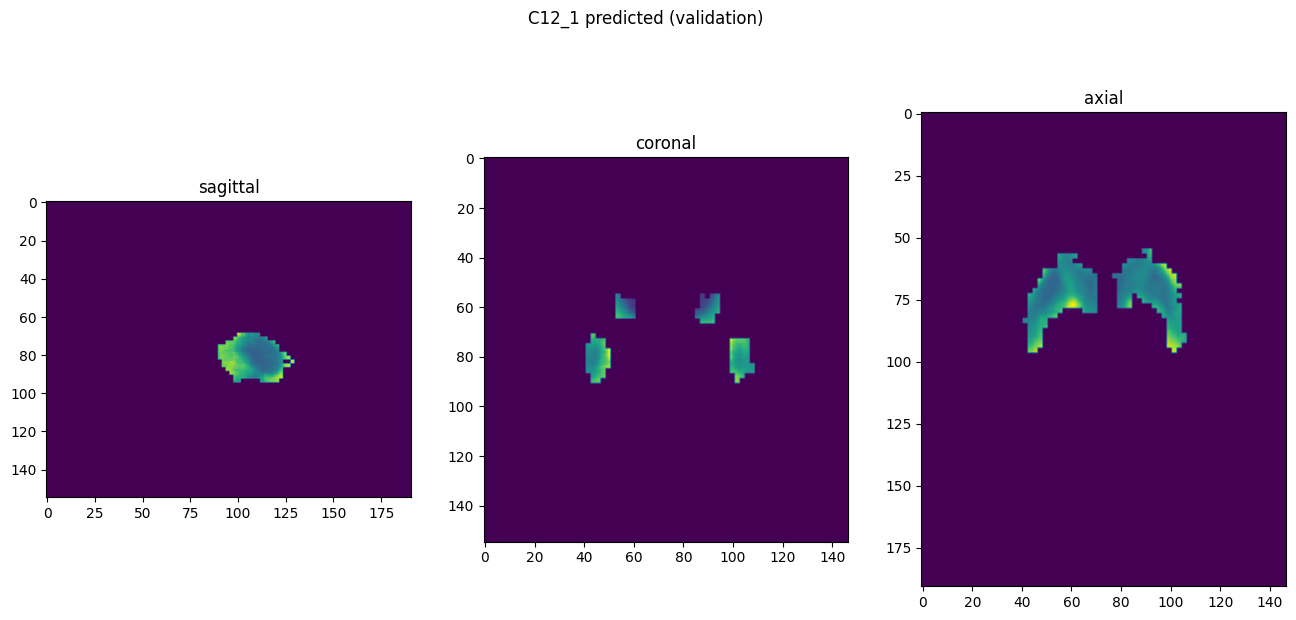

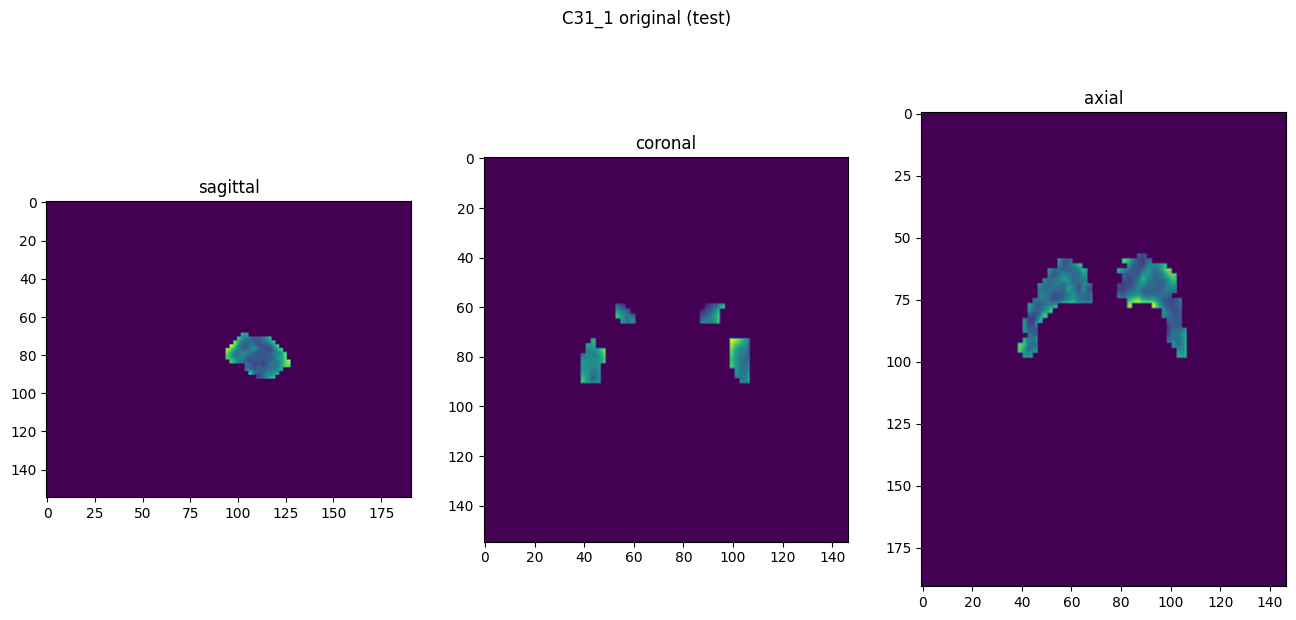

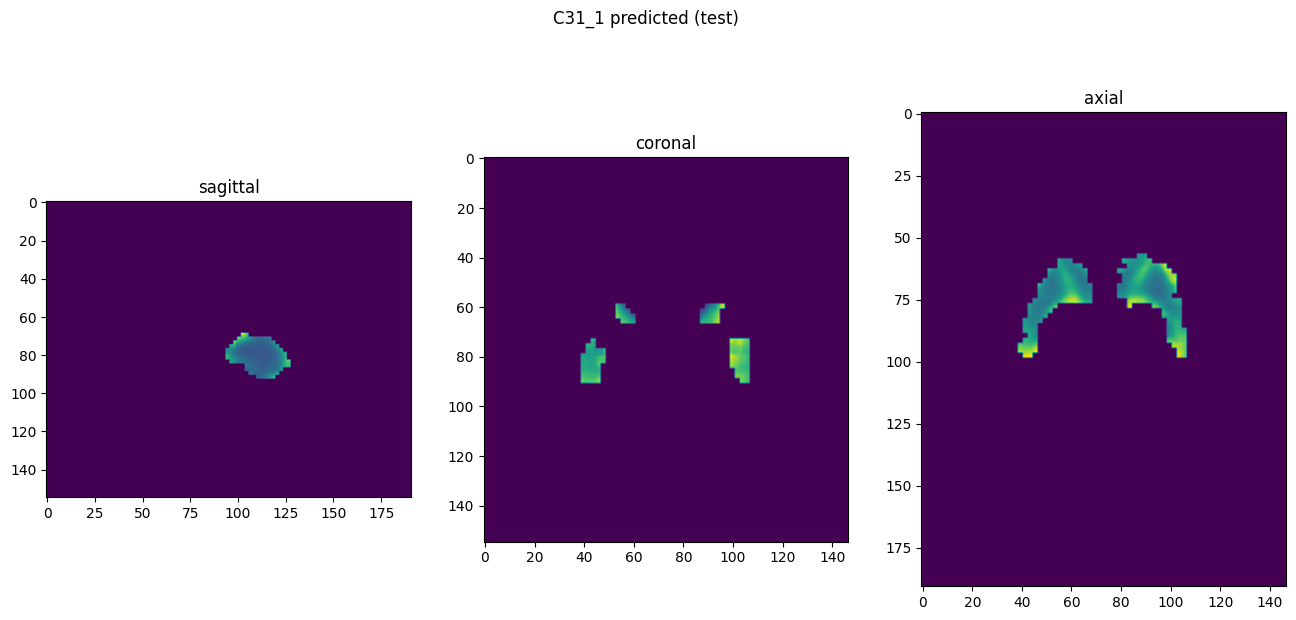

In [10]:
showResults(model, gen, threshold=None, background=False)